In [1]:
import os

import numpy as np
from tensorflow import keras
from tensorflow.keras.utils import plot_model
import cv2

import matplotlib.pyplot as plt
import ipympl

import image_handler as handler

In [2]:
model = keras.models.load_model("droplet_detection_model")

In [ ]:
images = []
for file in os.listdir("training_data"):
    if file.endswith(".jpg"):
        images.append(file)

images = sorted(images)

In [ ]:
for idx, image in enumerate(images):
    print(image)
    fig, ax = plt.subplots(ncols=2, sharex="all", sharey="all", figsize=(20, 10))

    img, _ = handler.load_test_image(os.path.join("training_data", image), circle_label=None)
    pred = model.predict(img)

    ax[0].imshow(img[0, :, :, :], cmap="gray")
    ax[1].imshow(pred[0, :, :, :], cmap="gray")
    
    fig.savefig(os.path.join("output_data", image), dpi=150, bbox_inches="tight")
    plt.close("all")

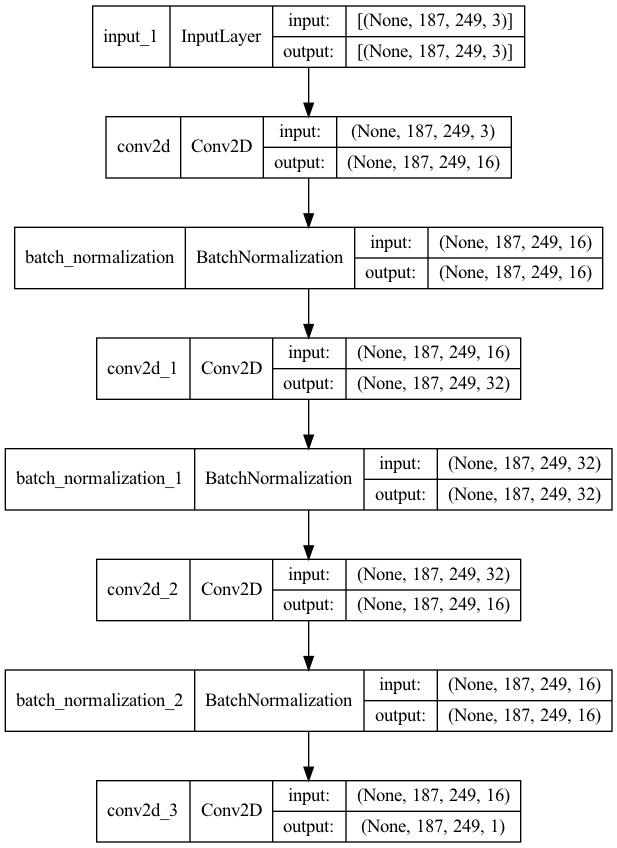

In [6]:
plot_model(model, to_file=os.path.join("results", "model.png"), show_shapes=True)